# Non-linear recharge models
*R.A. Collenteur, University of Graz*

This notebook explains the use of the `RechargeModel` stress model to simulate the combined effect of precipitation and potential evapotranspiration on the groundwater levels. For the computation of the actual recharge, different (non-linear) models are available. The non-linear models are introduced in Pastas 0.14 and will be described in more detail in Collenteur et al. (in Prep.). The `Berendrecht` model is already fully described in Berendrecht et al. (2006).

### Tip
To run this notebook and the related non-linear recharge models, it is strongly recommended to install Numba (http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of the recharge calculation, making the non-linear model as fast as the Linear recharge model.

### Input data
In this notebook we analyze a head time series near the town of De Bilt in the Netherlands. Data is obtained from the following resources:
- The heads (`B32C0639001.csv`) are downloaded from https://www.dinoloket.nl/ 
- The precipitation and evapotranspiration (`etmgeg_260.txt`) are downloaded from https://knmi.nl

### References
- Collenteur, R.A., Bakker, M., Birk, S. (in Preparation) Estimating groundwater recharge from observed groundwater levels using non-linear transfer function noise models.
- Berendrecht, W. L., Heemink, A. W., van Geer, F. C., and Gehrels, J. C. (2006) [A non-linear state space approach to model groundwater fluctuations](https://www.sciencedirect.com/science/article/abs/pii/S0309170805002113), Advances in Water Resources, 29, 959–973.

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib inline

ps.show_versions()
ps.set_log_level("ERROR")

Python version: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.0.5
Pastas version: 0.15.0b


## 1. Input data
Input data handling is similar to normal. The only thing that is necessary to check is that the precipitation and evaporation are provided in mm/day. This is necessary because the parameters for the unsaturated zone models are defined in mm for the length unit and days for the time unit. It is possible to use other units, but this would require manually setting the initial values and parameter boundaries for the recharge models.

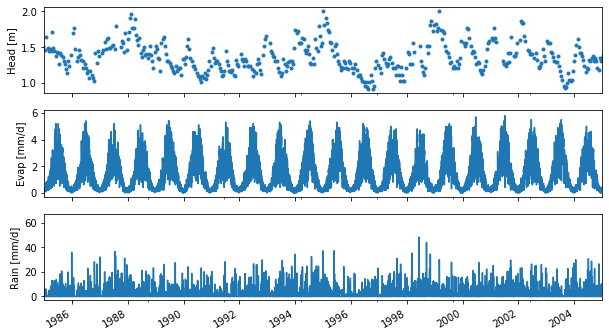

In [2]:
head = pd.read_csv("../data/B32C0639001.csv",  parse_dates=['date'], 
                   index_col='date', squeeze=True) 

# Make this millimeters per day
evap = ps.read_knmi("../data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("../data/etmgeg_260.txt", variables="RH").series * 1e3

fig, axes = plt.subplots(3,1, figsize=(10,6), sharex=True)
head.plot(ax=axes[0], x_compat=True, linestyle=" ", marker=".")
evap.plot(ax=axes[1], x_compat=True)
rain.plot(ax=axes[2], x_compat=True)
axes[0].set_ylabel("Head [m]")
axes[1].set_ylabel("Evap [mm/d]")
axes[2].set_ylabel("Rain [mm/d]")

plt.xlim("1985", "2005");

## 2. Make a basic model
1. Create a Pastas model
2. Choose and create a unsaturated zone model (you can choose from: `Linear`, `FlexModel`, and `Berendrecht`). All recharge models can be accessed through the recharge subpackage (`ps.rch`).
3. Create a `RechargeModel` object and add it to the model
4. Solve and visualize the model

Model Results head                   Fit Statistics
nfev     27                     EVP           89.45
nobs     351                    R2             0.89
noise    True                   RMSE           0.07
tmin     1990-01-01 00:00:00    AIC           21.06
tmax     2005-10-14 00:00:00    BIC           63.53
freq     D                      Obj            0.47
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           ___                

Parameters (8 were optimized)
                optimal   stderr     initial   vary
rch_A          0.427248   ±6.00%    0.721210   True
rch_n          0.668178   ±2.96%    1.000000   True
rch_a        300.022264  ±13.50%   10.000000   True
rch_su        54.702385   ±5.59%  250.000000   True
rch_lp         0.250000    ±nan%    0.250000  False
rch_ks        19.547379  ±11.15%  100.000000   True
rch_gamma      4.051118   ±9.43%    4.000000   True
rch_si         2.000000    ±nan%    2.000000  False
rch_kv         1.000000    ±nan% 

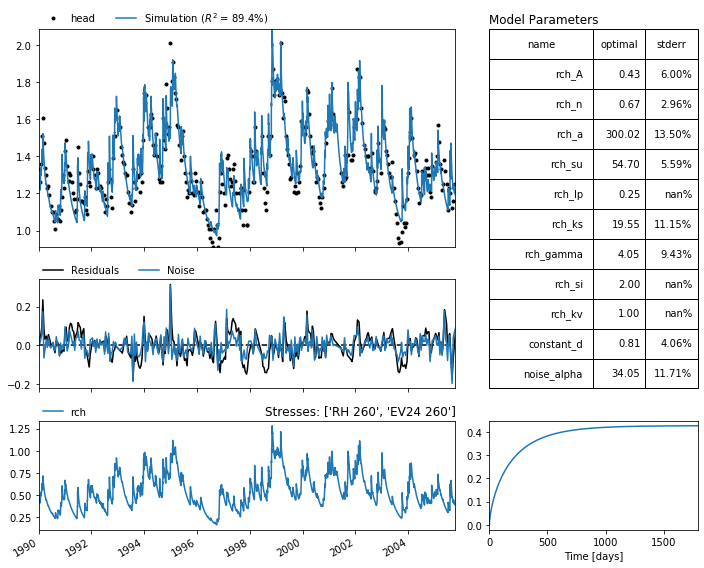

In [3]:
ml = ps.Model(head)

# Select a recharge model
rch = ps.rch.FlexModel()
#rch = ps.rch.Berendrecht()
#rch = ps.rch.Linear()

rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

ml.solve(noise=True, tmin="1990")
ml.plots.results();

## 3. Analyze the estimated recharge flux
After the parameter estimation we can take a look at the recharge flux computed by the model. The flux is easy to obtain using the `get_stress` method of the model object, which automatically provides the optimal parameter values that were just estimated. After this, we can for example look at the yearly recharge flux estimated by the Pastas model.

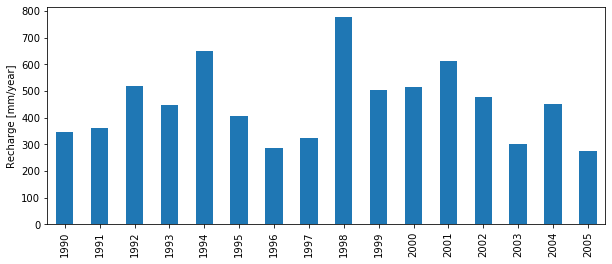

In [4]:
recharge = ml.get_stress("rch").resample("A").sum()
ax = recharge.plot.bar(figsize=(10,4))
ax.set_xticklabels(recharge.index.year)
plt.ylabel("Recharge [mm/year]");